In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import pandas as pd
import torch
import random
import math

from torch import nn

from prnn.utils.data import generate_trajectories, create_dataloader
from prnn.utils.env import make_env
from prnn.utils.agent import RandomActionAgent, RandomHDAgent, RatInABoxAgent
from prnn.utils.predictiveNet import PredictiveNet
import pynapple as nap

In [8]:
from ratinabox.Agent import Agent
from ratinabox.Neurons import *
from ratinabox.utils import get_angle, get_distances_between
from ratinabox.contribs.ValueNeuron import ValueNeuron

from prnn.utils.ActionEncodings import *
from prnn.utils.general import saveFig

In [9]:
import matplotlib.pyplot as plt

In [10]:
# env_key is the one you put in RatEnvironment.py
# package is the one you put in env.py

env = make_env(env_key='cheeseboard2', package='ratinabox_colors_Reward_Directed', act_enc='ContSpeedOnehotHD', FoV_params={"spatial_resolution": 0.05,
                           "angle_range": [0, 30],
                           "distance_range": [0.0, 1.2],
                           "beta": 10,
                           "walls_occlude": False
                           }) #add FoV here
agent = RatInABoxAgent('_')

'geodesic' wall geometry only supported for enivironments with 1 additional wall (4 bounding walls + 1 additional). Sorry. Using 'line_of_sight' instead.


/Users/hadrienpadilla/Library/Python/3.9/lib/python/site-packages/ratinabox/utils.py:895: UserWarning: Found 1 unexpected params key(s) while initializing FieldOfViewBVCs object: 'walls_occlude'.
If you intended to set this parameter, ignore this message. To see all default parameters for this class call FieldOfViewBVCs.get_all_default_params().
  warnings.warn(
/Users/hadrienpadilla/Documents/McGill/Peyrache Lab/pRNN/prnn/utils/Shell.py:654: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  facecolor = matplotlib.cm.get_cmap(self.env.object_colormap)


In [11]:
# to test if you collect observations correctly
# obs should be a tuple of two tensors
# act should be a tensor

obs, act, state, render = env.collectObservationSequence(agent, 100000) #try running with default parameters, if not for 100k try for more steps 

Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel changed to 0
Reward channel changed to 1
Reward channel changed to 2
Reward channel chang

In [12]:
total_steps = len(env.ag.history["t"])  
print("Total steps: ", total_steps)
#look at the history of the reward cell

Total steps:  100001


    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


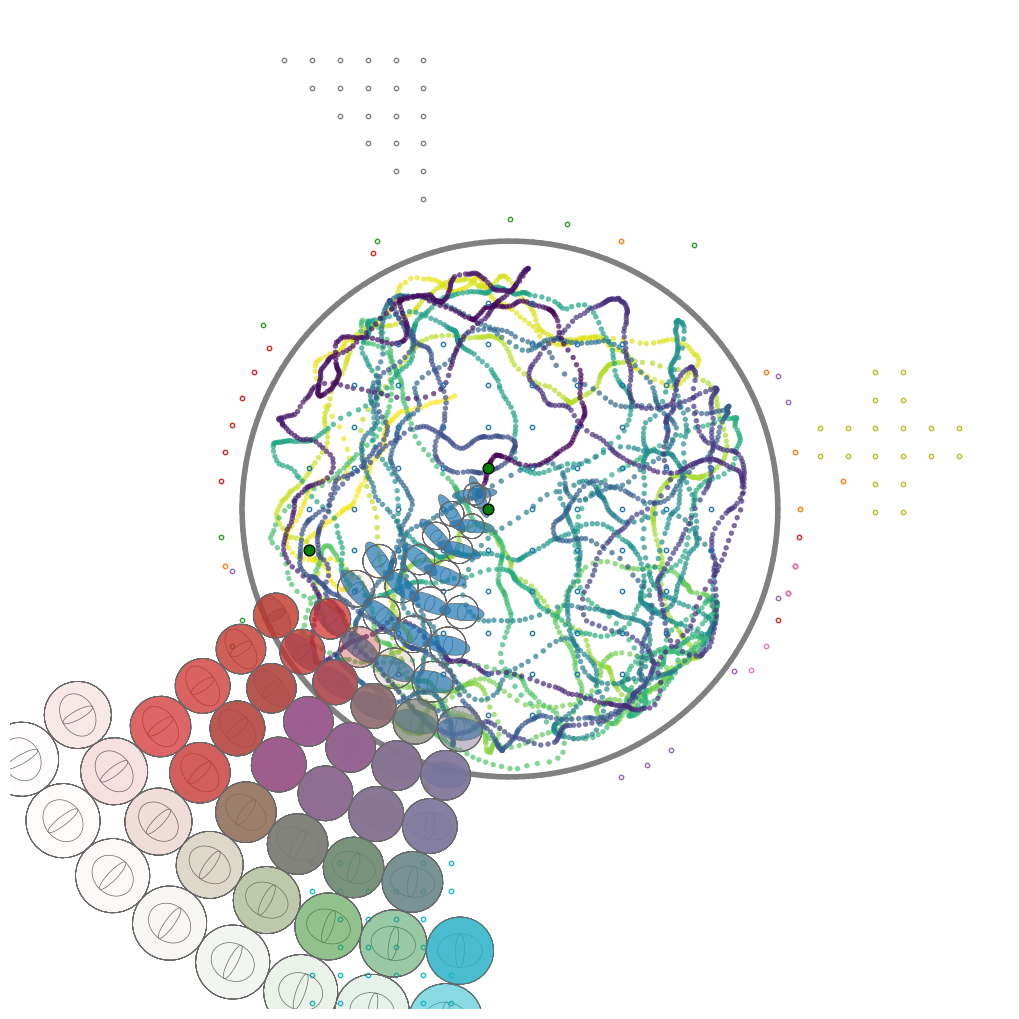

In [13]:
 
# fig = plt.figure(figsize=(10, 10))
# ax = plt.subplot(1,1,1)
fig, ax = plt.subplots(figsize=(10,10))
env.show_state_traj(90000, 100000, fig, ax) 

minmax : (0.027825903092295157, 1.1671512531970423, 0.01826904794266105, 1.1666957985762154)
pos    : [0.0278259  0.01826905] [1.16715125 1.1666958 ]


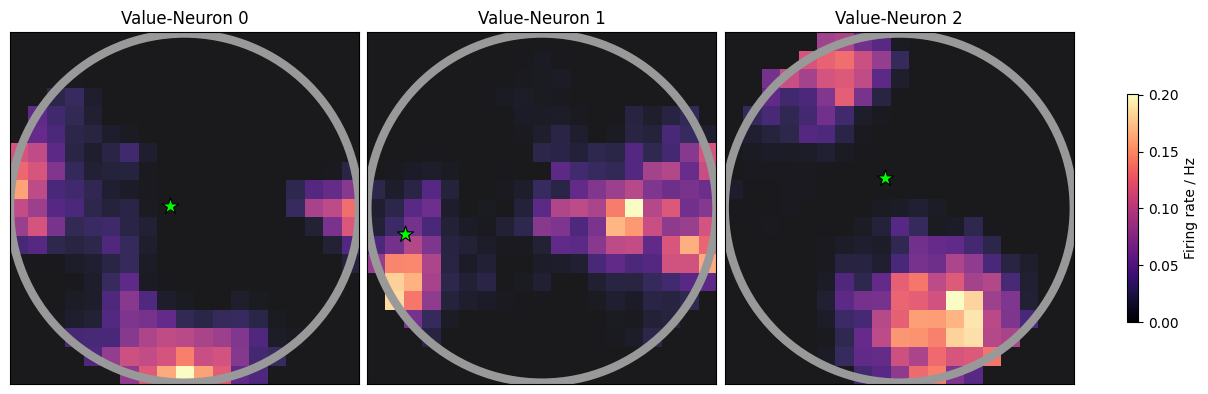

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pynapple as nap
from matplotlib.cm import magma

onsetTransient = 0
timesteps      = 100_000        # analyse this window
traj_slice     = slice(0, 10_000)   # red path like in show_state_traj

shell = env                     # your RiaBColorsRewardDirectedShell
riab  = shell.env               # underlying RatInABox Environment

# ------------------------------------------------------------------
# 1.  cut position + firing‑rate arrays to equal length ------------
# ------------------------------------------------------------------
pos_all = np.asarray(state['agent_pos'])
pos     = pos_all[onsetTransient : onsetTransient + timesteps]

fr = shell.all_firing_rates
if hasattr(fr, "detach"):
    fr = fr.detach().cpu().numpy()
rates = fr[onsetTransient : onsetTransient + timesteps]

T, n_neur = rates.shape
t_vec     = np.arange(onsetTransient, onsetTransient + timesteps)

# ------------------------------------------------------------------
# 2.  build TsdFrames and compute 2‑D rate‑maps with pynapple -------
# ------------------------------------------------------------------
dt = shell.ag.dt 
t_vec = np.arange(pos.shape[0]) * dt  # start at 0 s, step by dt

position = nap.TsdFrame(t=t_vec, d=pos, columns=("x", "y"),
                        time_units="s")

# --- keep rates in Hz; pynapple handles the normalisation ----------
rates_ts = nap.TsdFrame(t=t_vec, d=rates, time_units="s")
nbx, nby, _ = shell.get_map_bins()        # keep the bin counts
minmax = (pos[:,0].min(), pos[:,0].max(),  # x‑min, x‑max
          pos[:,1].min(), pos[:,1].max())  # y‑min, y‑max

print("minmax :", minmax)                  # what the bins expect
print("pos    :", pos.min(0), pos.max(0))  # what you actually give

place_fields, occupancy = nap.compute_2d_tuning_curves_continuous(
        rates_ts, position,
        ep=rates_ts.time_support,
        nb_bins=(nbx, nby),
        minmax=minmax)

# mask bins that were never visited
for nid in place_fields.keys():
    m          = place_fields[nid]
    m[occupancy == 0] = np.nan        # or 0 if you prefer
    place_fields[nid] = m

# ------------------------------------------------------------------
# 3.  helper: draw one map on the arena ----------------------------
# ------------------------------------------------------------------
def draw_map(rate_map, ax):

    vmax_val = np.nanmax(rate_map)
    if vmax_val == 0 or np.isnan(vmax_val):
        vmax_val = 1e-3

    # ------------------------------------------------------------------
    # 1.  show rate‑map (already in bin‑space coords)
    # ------------------------------------------------------------------
    ax.imshow(rate_map, origin="lower", extent=minmax,
              cmap=magma, vmin=0, vmax=vmax_val, alpha=0.9, zorder=0)

    

    # ------------------------------------------------------------------
    # 2.  arena outline IN THE SAME FRAME
    # ------------------------------------------------------------------
    cx = (minmax[0] + minmax[1]) / 2    # centre x
    cy = (minmax[2] + minmax[3]) / 2    # centre y
    radius = (minmax[1] - minmax[0]) / 2
    ax.add_patch(Circle((cx, cy), radius,
                        fc="none", ec="0.6", lw=6, zorder=2))

    rewards = np.asarray(env.reward_positions)        # shape (n_rew, 2)

    # ‑‑‑ if you earlier rescaled/shifted the trajectory, do the same here:
    # rewards = (rewards - track_min) * scale            #  only if you scaled pos
    # rewards = rewards + shift                          #  only if you shifted pos

    # ax.scatter(rewards[:, 0], rewards[:, 1],
    #            marker="*", s=150, facecolors="lime",
    #            edgecolors="black", linewidths=0.8, zorder=3)

    ax.set_xticks([]); ax.set_yticks([])


# ------------------------------------------------------------------
# 4.  figure: one panel per Value‑Neuron ---------------------------
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, n_neur, figsize=(4*n_neur,4),
                         constrained_layout=True,
                         subplot_kw={'aspect':'equal'})

if n_neur == 1:
    axes = [axes]

rewards = np.asarray(env.reward_positions)        # shape (n_rew, 2)

for ax, (nid, m) in zip(axes, place_fields.items()):
    draw_map(m, ax)
    ax.set_title(f"Value‑Neuron {nid}")
    ax.scatter(rewards[nid, 0], rewards[nid, 1],
               marker="*", s=150, facecolors="lime",
               edgecolors="black", linewidths=0.8, zorder=3)

# shared colour‑bar
sm = plt.cm.ScalarMappable(cmap=magma,
                           norm=plt.Normalize(vmin=min(np.nanmin(m) for m in place_fields.values()),
                                              vmax=max(np.nanmax(m) for m in place_fields.values())))
fig.colorbar(sm, ax=axes, shrink=0.6, label="Firing rate / Hz")


plt.show()


In [1]:
print("raw ValNeur firing samples (first 10 timesteps):")
print(shell.all_firing_rates[:10])

print("\nmin / max over 50 000 steps")
print("min:", rates.min(), "   max:", rates.max())


raw ValNeur firing samples (first 10 timesteps):


NameError: name 'shell' is not defined

In [ ]:

prednet = PredictiveNet(env, pRNNtype='multRNN_5win_i01_o01')

In [ ]:
# to test if pRNN works correctly with these observations

obs_pred, _, _ = prednet.predict(obs, act)

In [ ]:

env.vision[1].sigma_distances

print(env.vision[1].sigma_distances.shape)
test_distances = np.full((60,), 0.5)
env.vision[1].sigma_distances
test_distances


(60,)


array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [ ]:
env.vision[1].sigma_angles
test_angles = np.full((60,), 5.)

obs shape:  torch.Size([1, 100001, 180])
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)
(921600,)


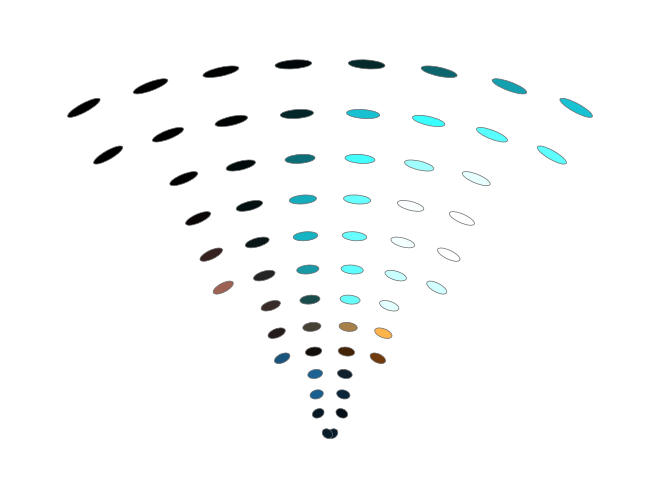

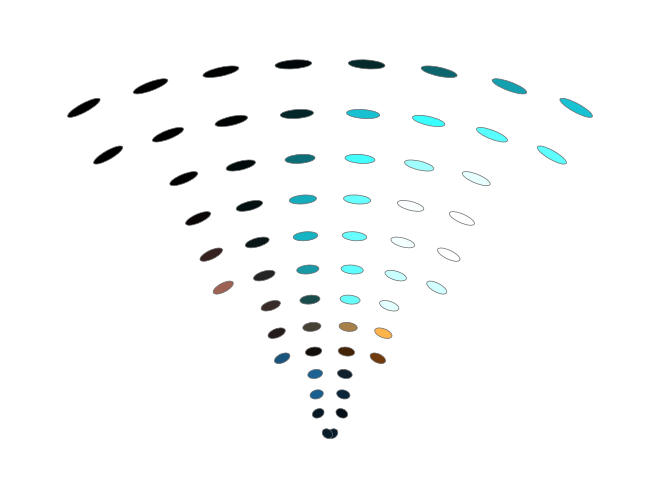

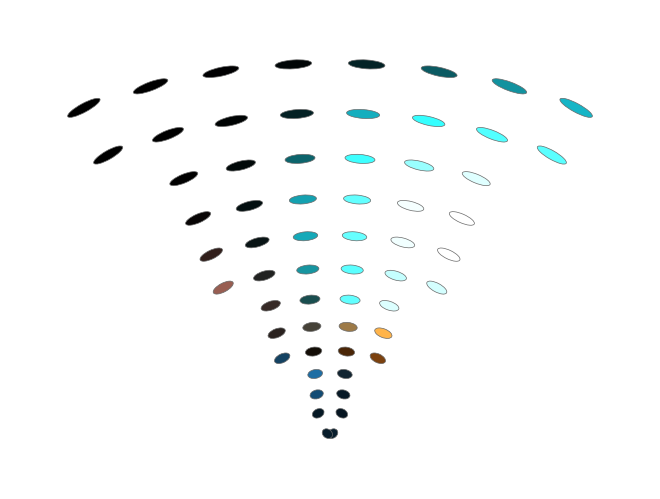

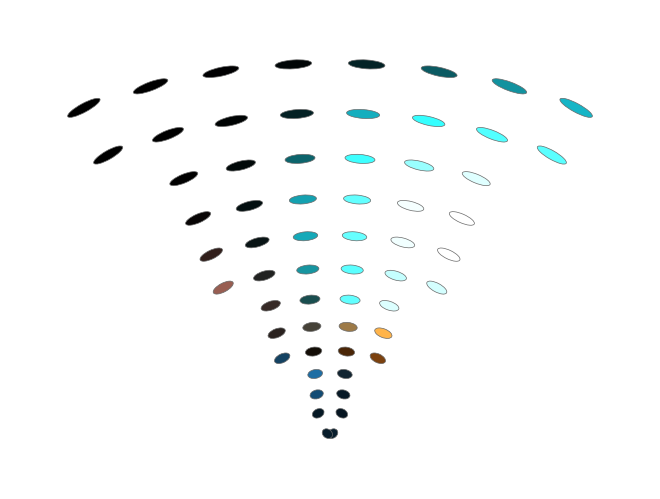

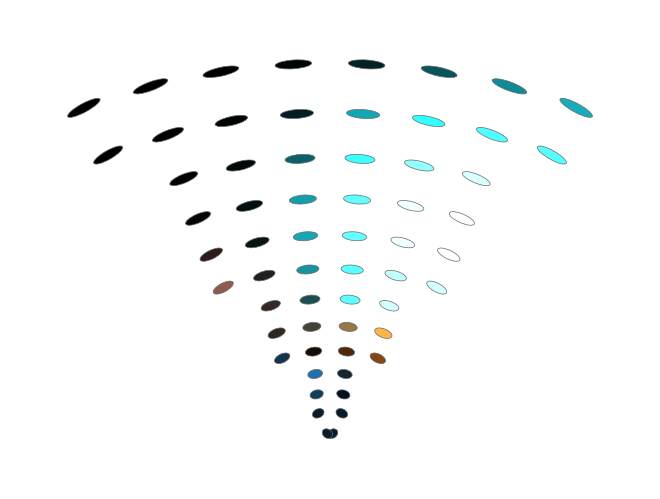

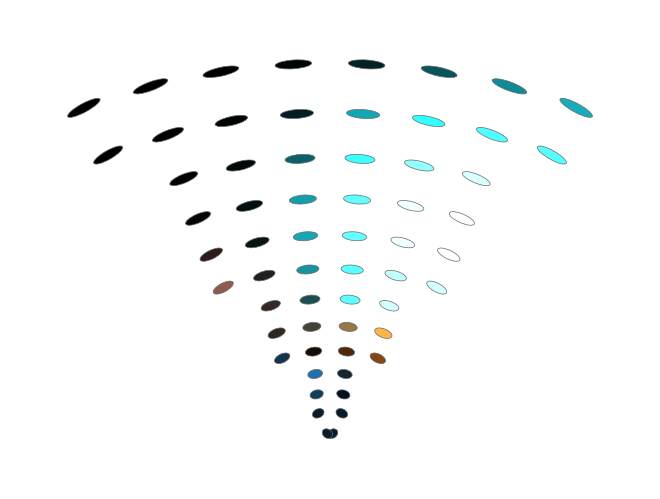

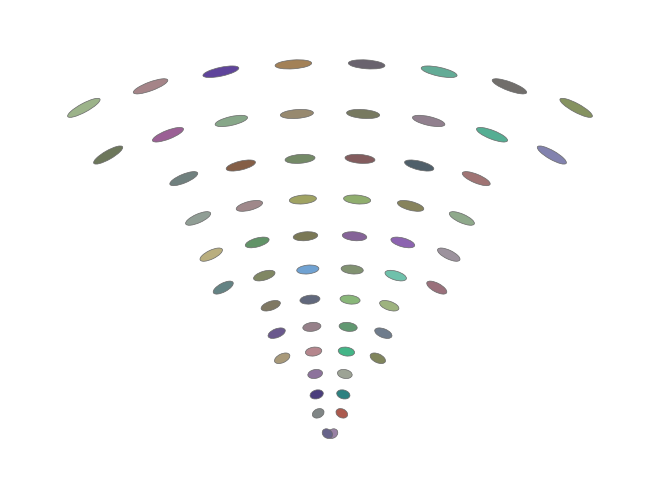

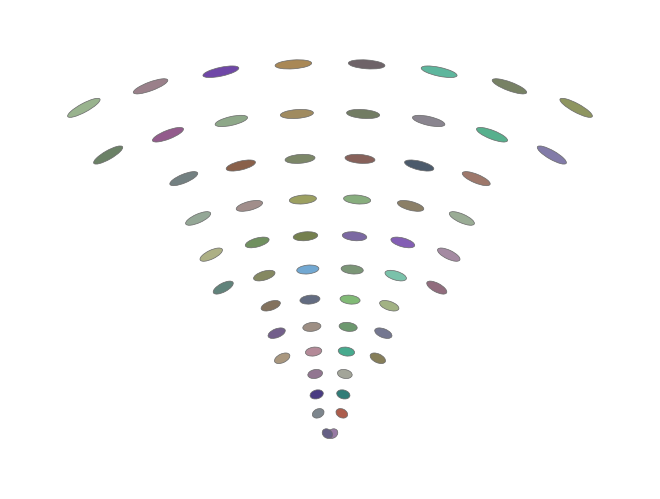

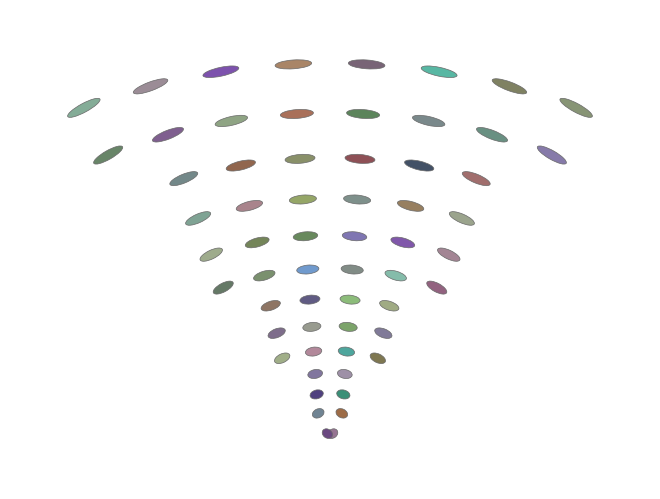

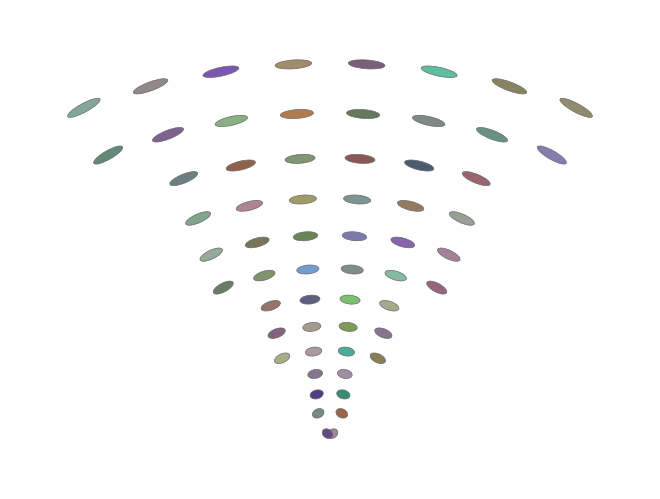

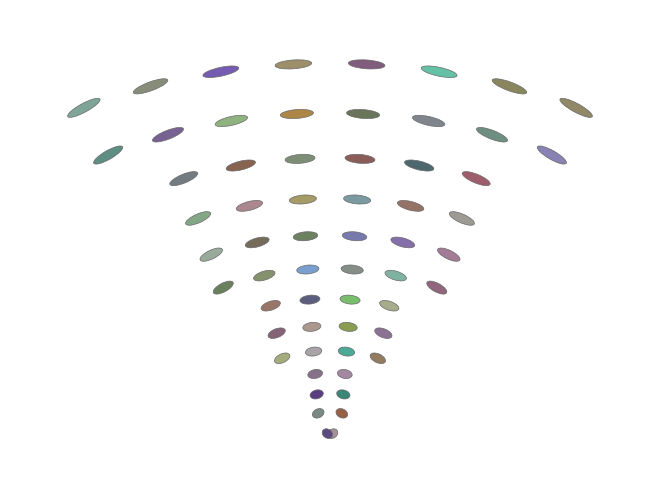

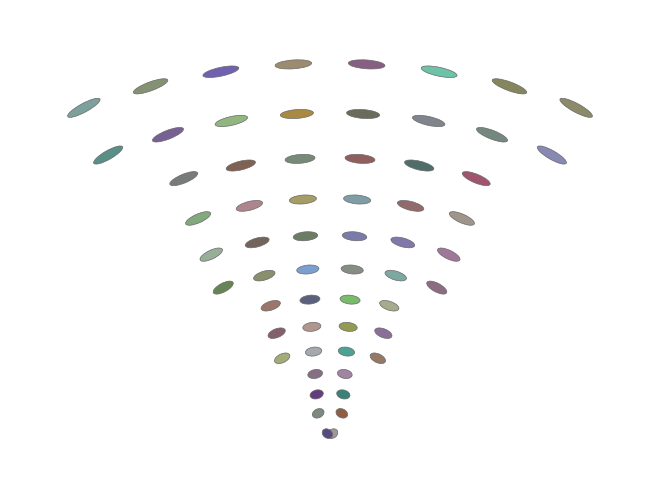

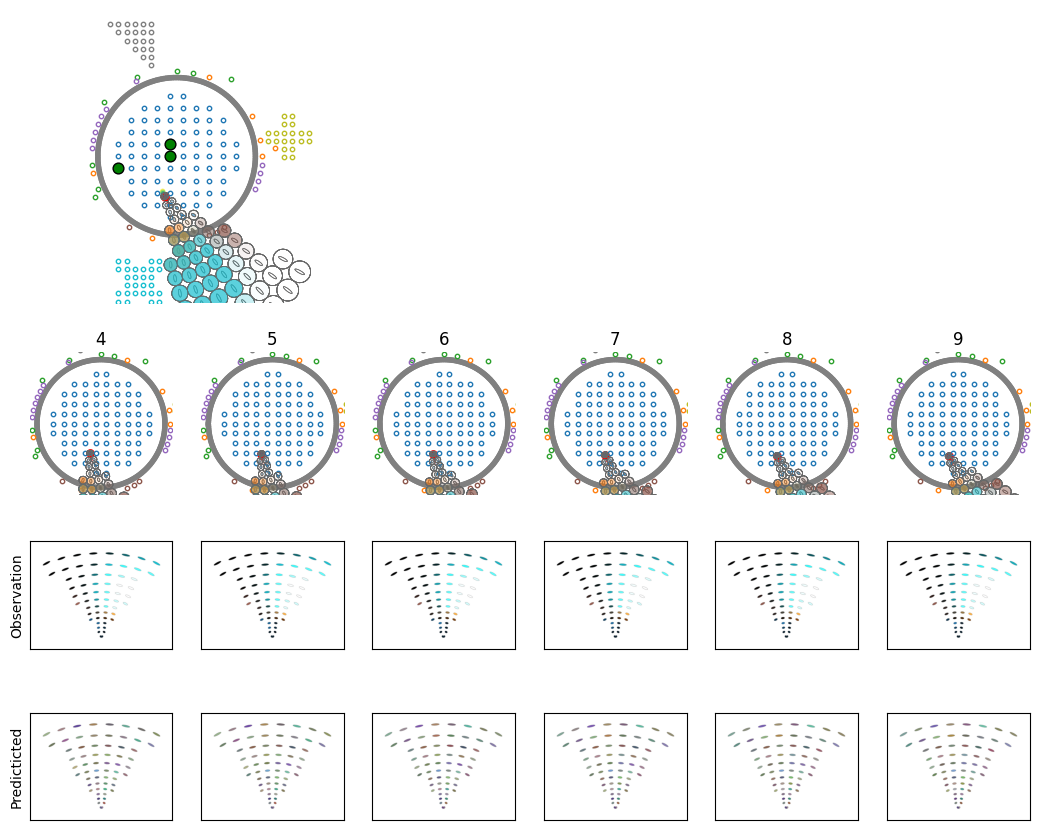

In [ ]:
print("obs shape: ", obs[0].shape)
prednet.plotObservationSequence(obs, render, obs_pred, state, timesteps=range(4,10))

In [ ]:
# when you're sure that everything's set, you may want to generate some data with this
# it will save a bunch of trajectories in the folder you specify, and then you can train pRNNs faster
# withput having to collect data every time

#generate_trajectories(env, agent, n_trajs=10240, seq_length=1000, folder='Data')
generate_trajectories(env, agent, n_trajs=100, seq_length=1000, folder='Data')

Found existing data, will generate more data if needed


In [ ]:
create_dataloader(env, agent, 100, 1000,
                          'Data', batch_size=4, num_workers=1)

Found existing data, will generate more data if needed


In [ ]:
# when you have data generated, you can test if everything goes smoothly with this

prednet.useDataLoader = True
prednet.trainingEpoch(env, agent,
                            sequence_duration=500,
                            num_trials=10,
                            batch_size=2)

Training pRNN on cpu...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x160 and 196x500)

In [ ]:
# when you will have nets already trained, this function is what you need to load them
# by default your path should be what comes after "nets/" and before ".pkl"

prednet = PredictiveNet.loadNet('PATH TO YOUR NET')

FileNotFoundError: [Errno 2] No such file or directory: 'nets/PATH TO YOUR NET.pkl'

In [ ]:
# At some point this may be helpful to debug the whole pipeline, you'll just need to change some parameters below


%run trainNet_prnn.py --savefolder='test/' --pRNNtype='multRNN_5win_i01_o01' \
        --sparsity=0.1 --mean_std_ratio=1 --eg_weight_decay=1e-8 --eg_lr=2e-3 \
        --env='cheeseboard' --env_package='ratinabox_colors_Reward' --agent='RatInABoxAgent' \
        --seqdur=1000 --lr=2e-3 --numepochs=6 --numtrials=1024 --hiddensize=500 --noisestd=0.05 \
        --bias_lr=0.2 --trainBias --ntimescale=2 --actenc='ContSpeedOnehotHD' --batch_size=8 --datasetSize=10240 \
        --datasetfolder='/Data' --namext='ContSpeedOnehotHD' -s=8 --saveTrainData #TODO: update data